This notebook has to do with confounders. In particular, it generate the correlograms included in the manuscripts, and test whether associations between predicted and observed values holds after including prevailing levels of cardiovascular disease risk.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import sys
import seaborn as sns
from scipy.spatial.distance import squareform

sys.path.append("..")
from src.harmonization import norm_standardize_my
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import ks_2samp, ttest_ind, bartlett, pearsonr, zscore

import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer

class ByStudyImputer(SimpleImputer):
    
    def fit(self, X, mask=None):
        if np.any(mask):
            X = X[mask]
        return super().fit(X)
        
    def transform(self, X, mask=None):
        
        if np.any(mask):
            X_transf = X.copy()
            X_transf[mask] = super().transform(X[mask])
        else:
            X_transf = super().transform(X)
        return X_transf
    
class ByStudyTransformer():
    
    def __init__(self,
                 transformer
                ):
        
        self.transformer = transformer
    
    def fit(self, X, mask=None):
        if np.any(mask):
            X = X[mask]
        return self.transformer.fit(X)
        
    def transform(self, X, mask=None):
        
        if np.any(mask):
            X_transf = X.copy()
            X_transf[mask] = self.transformer.transform(X[mask])
        else:
            X_transf = self.transformer.transform(X)
        return X_transf
    
def impute_standardize(dat_train, study_train, dat_test, study_test):
    imp = ByStudyImputer(strategy="median")

    var_train = dat_train[:,np.newaxis]
    var_test = dat_test[:,np.newaxis]

    imp.fit(var_train, mask=(study_train=="PIP").to_numpy())
    var_train = imp.transform(var_train, mask=(study_train=="PIP").to_numpy())
    var_test = imp.transform(var_test, mask=(study_test=="PIP").to_numpy())

    imp.fit(var_train, mask=(study_train=="NOAH").to_numpy())
    var_train = imp.transform(var_train, mask=(study_train=="NOAH").to_numpy())
    var_test = imp.transform(var_test, mask=(study_test=="NOAH").to_numpy())

    ss_study = ByStudyTransformer(transformer=StandardScaler())

    ss_study.fit(var_train, mask=(study_train=="PIP").to_numpy())
    var_train = ss_study.transform(var_train, mask=(study_train=="PIP").to_numpy())
    var_test = ss_study.transform(var_test, mask=(study_test=="PIP").to_numpy())

    ss_study.fit(var_train, mask=(study_train=="NOAH").to_numpy())
    var_train = ss_study.transform(var_train, mask=(study_train=="NOAH").to_numpy())
    var_test = ss_study.transform(var_test, mask=(study_test=="NOAH").to_numpy())

    return var_train.flatten(), var_test.flatten()

def impute_harmonize(dat_train, study_train, dat_test, study_test):
    imp = ByStudyImputer(strategy="median")

    var_train = dat_train[:,np.newaxis]
    var_test = dat_test[:,np.newaxis]

    imp.fit(var_train, mask=(study_train=="PIP").to_numpy())
    var_train = imp.transform(var_train, mask=(study_train=="PIP").to_numpy())
    var_test = imp.transform(var_test, mask=(study_test=="PIP").to_numpy())

    imp.fit(var_train, mask=(study_train=="NOAH").to_numpy())
    var_train = imp.transform(var_train, mask=(study_train=="NOAH").to_numpy())
    var_test = imp.transform(var_test, mask=(study_test=="NOAH").to_numpy())

    var_train, var_test = norm_standardize_my(var_train.flatten(), study_train, var_test.flatten(), study_test)

    return var_train.to_numpy(), var_test.to_numpy()

def impute(dat_train, study_train, dat_test, study_test):
    imp = ByStudyImputer(strategy="median")

    var_train = dat_train[:,np.newaxis]
    var_test = dat_test[:,np.newaxis]

    imp.fit(var_train, mask=(study_train=="PIP").to_numpy())
    var_train = imp.transform(var_train, mask=(study_train=="PIP").to_numpy())
    var_test = imp.transform(var_test, mask=(study_test=="PIP").to_numpy())

    imp.fit(var_train, mask=(study_train=="NOAH").to_numpy())
    var_train = imp.transform(var_train, mask=(study_train=="NOAH").to_numpy())
    var_test = imp.transform(var_test, mask=(study_test=="NOAH").to_numpy())

    return var_train.flatten(), var_test.flatten()

def preprocess_cohorts_cv(dat_train, study_train, dat_test, study_test, harmonize=None):
    if harmonize is None:
        var_train, var_test = impute(dat_train, study_train, dat_test, study_test)
    elif harmonize == "harmonize":
        var_train, var_test = impute_harmonize(dat_train, study_train, dat_test, study_test)
    elif harmonize == "standardize":
        var_train, var_test = impute_standardize(dat_train, study_train, dat_test, study_test)
    else:
        raise ValueError("'harmonize' should take None, 'harmonize' or 'standardize'")
        
    return var_train, var_test

In [2]:
project_data = pd.read_csv("../data/final_data_2023-01-25_w10cvd.csv")
project_data.head()

,ID,STUDY,age_mri,arousal_baseline,arousal_msit,arousal_reactivity_both,arousal_reactivity_msit,arousal_reactivity_stroop,arousal_stroop,bmi_std,...,valence_reactivity_both,valence_reactivity_msit,valence_reactivity_stroop,valence_stroop,waist_in,wght,yrs_sch,ascvd_10y,fwd_stroop,fwd_msit
0,P1002,PIP,35.465753,5.0,3.0,0.0,-2.0,2.0,7.0,20.299948,...,-0.5,0.0,-1.0,6.0,27.0,111.0,24.0,1.0,0.450081,0.165285
1,P1003,PIP,37.758904,5.0,3.0,0.0,-2.0,2.0,7.0,31.730671,...,-0.5,0.0,-1.0,6.0,35.0,182.0,14.0,1.0,0.220844,0.188768
2,P1004,PIP,33.339726,1.0,3.0,2.5,2.0,3.0,4.0,24.273780,...,-1.5,-1.0,-2.0,6.0,31.0,155.0,18.0,1.0,0.140789,0.129827
3,P1006,PIP,46.435616,1.0,5.0,5.0,4.0,6.0,7.0,28.580419,...,-2.0,-2.0,-2.0,3.0,31.0,182.5,16.0,1.0,0.142839,0.142936
4,P1007,PIP,41.413699,1.0,3.0,2.0,2.0,2.0,3.0,24.692149,...,-2.5,-1.0,-4.0,5.0,30.5,153.0,16.0,1.0,0.153666,0.134968


In [3]:
my_vars = ["mavg_bulbf_ccaf", "sbp_reactivity_both", "sbp_auc_g_both", "sbp_auc_i_both"]
covariates = ["age_mri", "waist_in", "sbpsitmri", "glucose", "hdl", "trigs", "ascvd_10y"]

# 1- Inspection of distributions across cohorts

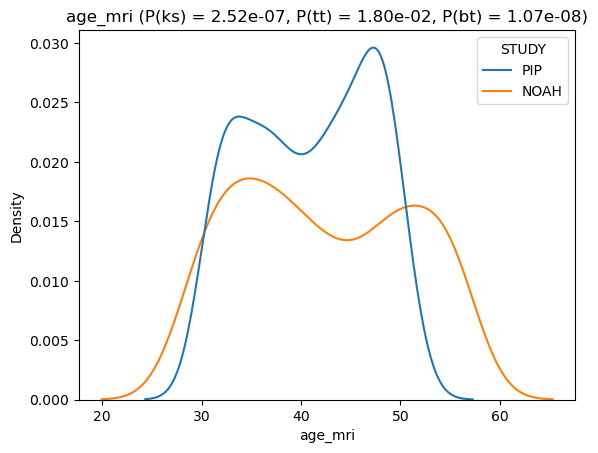

<Figure size 640x480 with 0 Axes>

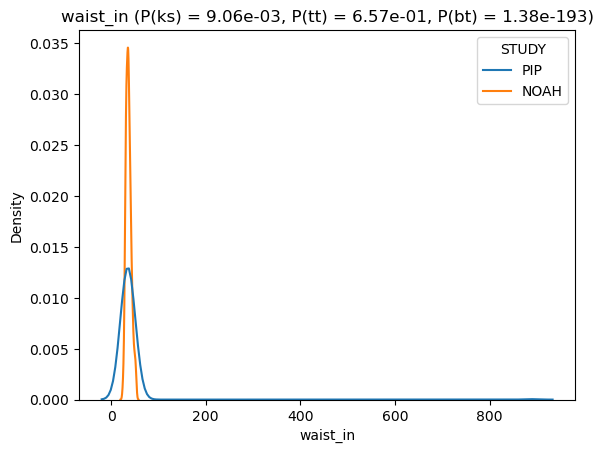

<Figure size 640x480 with 0 Axes>

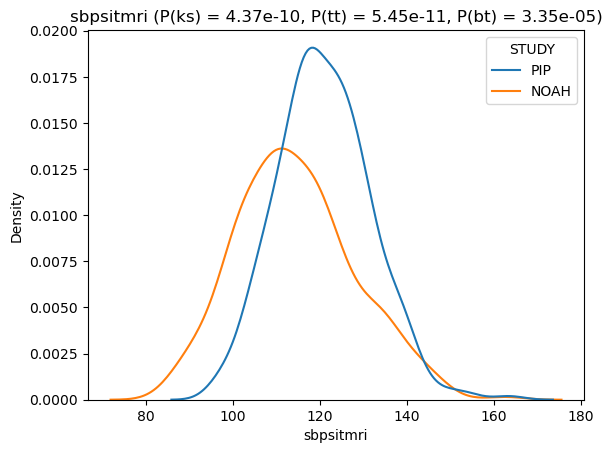

<Figure size 640x480 with 0 Axes>

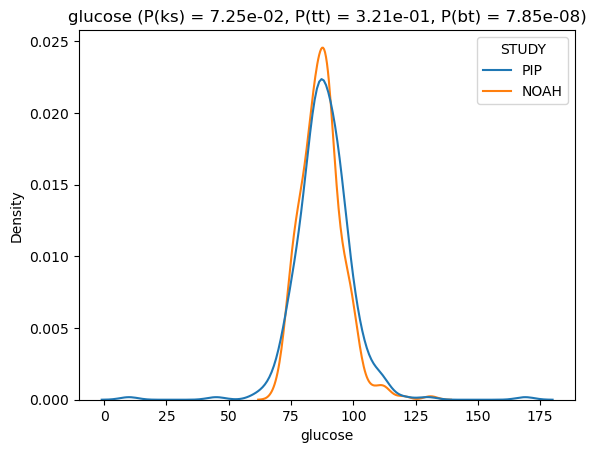

<Figure size 640x480 with 0 Axes>

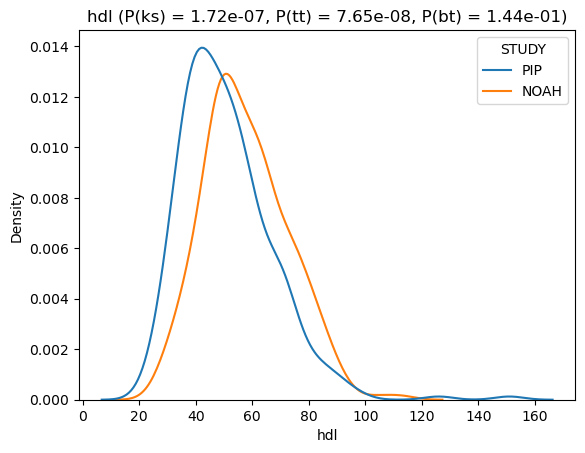

<Figure size 640x480 with 0 Axes>

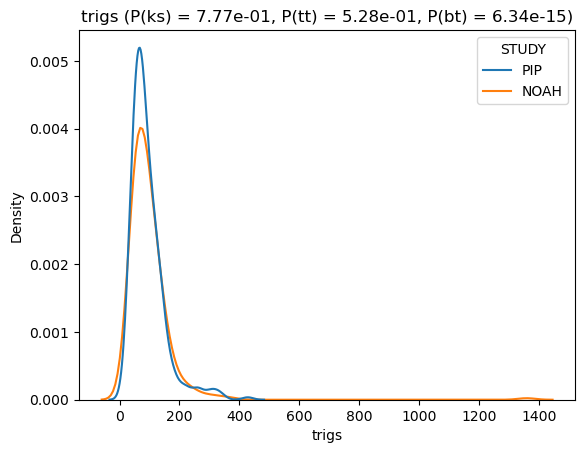

<Figure size 640x480 with 0 Axes>

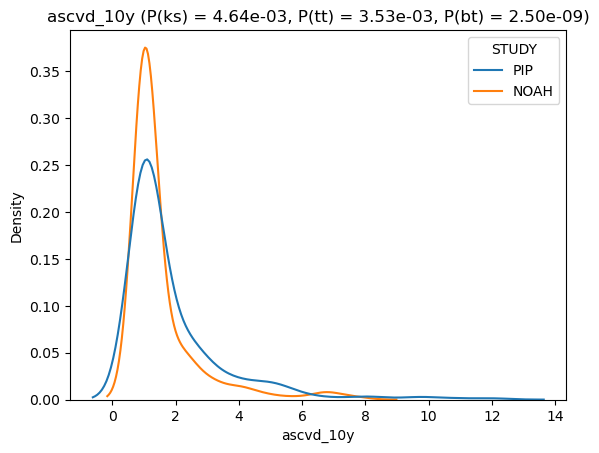

<Figure size 640x480 with 0 Axes>

In [4]:
for var in covariates:
    
    _, pks = ks_2samp(project_data.groupby("STUDY").get_group("PIP")[var], 
                    project_data.groupby("STUDY").get_group("NOAH")[var])
    _, ptt = ttest_ind(project_data.groupby("STUDY").get_group("PIP")[var], 
                    project_data.groupby("STUDY").get_group("NOAH")[var], nan_policy='omit')
    _, pbt = bartlett(project_data.groupby("STUDY").get_group("PIP")[var], 
                    project_data.groupby("STUDY").get_group("NOAH")[var])
    plt.figure()
    sns.kdeplot(x=var, hue="STUDY", data=project_data)
    plt.title(f"{var} (P(ks) = {pks:.2e}, P(tt) = {ptt:.2e}, P(bt) = {pbt:.2e})")
    plt.figure()

# 2- Correlations between covariates and mediators and outcome variable

In [5]:
from scipy.stats import pearsonr
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]


data_group = project_data.groupby("STUDY")[my_vars + covariates]

cormat_pip = data_group.get_group("PIP").corr("pearson")
cormat_noah = data_group.get_group("NOAH").corr("pearson")

pv_pip = data_group.get_group("PIP").corr(method=pearsonr_pval)
pv_noah = data_group.get_group("NOAH").corr(method=pearsonr_pval)

pv_fdr = multipletests(np.concatenate((squareform(pv_pip, checks=False),
                                       squareform(pv_noah, checks=False))),
                       method="fdr_bh")[1]

pv_pip_fdr = squareform(pv_fdr[:int(len(pv_fdr)/2)])
np.fill_diagonal(pv_pip_fdr, 1) 
pv_pip_fdr = pd.DataFrame(pv_pip_fdr, 
                          columns = pv_pip.columns, index=pv_pip.index)

pv_noah_fdr = squareform(pv_fdr[int(len(pv_fdr)/2):])
np.fill_diagonal(pv_noah_fdr, 1) 
pv_noah_fdr = pd.DataFrame(pv_noah_fdr, 
                           columns = pv_noah.columns, index=pv_noah.index)

renamed_vars = ['CA-IMT', r'$\Delta$' + 'SBP', "SBP_" + r'${\rm AUC}_{\rm g}$', 
                "SBP_" + r'${\rm AUC}_{\rm i}$', "age",  "waist", "clinic-SBP", "glucose", "hdl", "trigs", "ascvd_10y"]
cormat_pip.columns = renamed_vars
cormat_pip.index = renamed_vars
cormat_noah.columns = renamed_vars
cormat_noah.index = renamed_vars

pv_pip_fdr.columns = renamed_vars
pv_pip_fdr.index = renamed_vars
pv_noah_fdr.columns = renamed_vars
pv_noah_fdr.index = renamed_vars


np.fill_diagonal(cormat_pip.values, np.nan)
np.fill_diagonal(cormat_noah.values, np.nan)

Show association between outcome, mediators and ascvd_10y

In [6]:
print(f"CA-IMT vs ASCVD_10y (PIP): {cormat_pip.loc['ascvd_10y', 'CA-IMT'].round(3)}, {pv_pip_fdr.loc['ascvd_10y', 'CA-IMT']}")
      
print(f"CA-IMT vs ASCVD_10y (NOAH): {cormat_noah.loc['ascvd_10y', 'CA-IMT'].round(3)}, {pv_noah_fdr.loc['ascvd_10y', 'CA-IMT']}")

CA-IMT vs ASCVD_10y (PIP): 0.32, 6.734041723676564e-08
CA-IMT vs ASCVD_10y (NOAH): 0.388, 1.049401791850908e-10


In [7]:
for m_var in ["$\Delta$SBP", 'SBP_' + r'${\rm AUC}_{\rm g}$', 'SBP_' + r'${\rm AUC}_{\rm i}$']:
    print(m_var)
    
    print(f"PIP, {m_var} vs CA-IMT", 
          cormat_pip.loc[m_var,"CA-IMT"].round(3), pv_pip_fdr.loc[m_var,"CA-IMT"].round(3))
    print(f"NOAH, {m_var} vs CA-IMT", 
          cormat_noah.loc[m_var,"CA-IMT"].round(3), pv_noah_fdr.loc[m_var, "CA-IMT"].round(3))
    
    print(f"PIP, {m_var} vs ascvd_10y", 
          cormat_pip.loc[m_var,"ascvd_10y"].round(3), pv_pip_fdr.loc[m_var,"ascvd_10y"].round(3))
    print(f"NOAH, {m_var} vs ascvd_10y", 
          cormat_noah.loc[m_var,"ascvd_10y"].round(3), pv_noah_fdr.loc[m_var,"ascvd_10y"].round(3))

    print(" ")

$\Delta$SBP
PIP, $\Delta$SBP vs CA-IMT 0.096 0.151
NOAH, $\Delta$SBP vs CA-IMT 0.088 0.243
PIP, $\Delta$SBP vs ascvd_10y -0.01 0.928
NOAH, $\Delta$SBP vs ascvd_10y 0.047 0.592
 
SBP_${\rm AUC}_{\rm g}$
PIP, SBP_${\rm AUC}_{\rm g}$ vs CA-IMT 0.25 0.0
NOAH, SBP_${\rm AUC}_{\rm g}$ vs CA-IMT 0.404 0.0
PIP, SBP_${\rm AUC}_{\rm g}$ vs ascvd_10y 0.286 0.0
NOAH, SBP_${\rm AUC}_{\rm g}$ vs ascvd_10y 0.251 0.0
 
SBP_${\rm AUC}_{\rm i}$
PIP, SBP_${\rm AUC}_{\rm i}$ vs CA-IMT 0.079 0.242
NOAH, SBP_${\rm AUC}_{\rm i}$ vs CA-IMT 0.092 0.22
PIP, SBP_${\rm AUC}_{\rm i}$ vs ascvd_10y -0.012 0.927
NOAH, SBP_${\rm AUC}_{\rm i}$ vs ascvd_10y 0.093 0.221
 


Show degrees of freedom to use when reporting correlation coefficients in the manuscript

In [8]:
def cors_df(x,y):
    df = len(x)
    df -= sum(x!=x)  | sum(y!=y)
    df -= 2
    return int(df)


data_group = project_data.groupby("STUDY")[my_vars + covariates]

dfs_cor_pip = data_group.get_group("PIP").corr(method=cors_df).astype(int)
dfs_cor_noah = data_group.get_group("NOAH").corr(method=cors_df).astype(int)

# PIP
dfs_cor_pip.loc[my_vars + ["ascvd_10y"],my_vars + ["ascvd_10y"]]


,mavg_bulbf_ccaf,sbp_reactivity_both,sbp_auc_g_both,sbp_auc_i_both,ascvd_10y
mavg_bulbf_ccaf,1,320,317,317,300
sbp_reactivity_both,320,1,316,316,297
sbp_auc_g_both,317,316,1,317,296
sbp_auc_i_both,317,316,317,1,296
ascvd_10y,300,297,296,296,1


In [9]:
# NOAH
dfs_cor_noah.loc[my_vars + ["ascvd_10y"],my_vars + ["ascvd_10y"]]

,mavg_bulbf_ccaf,sbp_reactivity_both,sbp_auc_g_both,sbp_auc_i_both,ascvd_10y
mavg_bulbf_ccaf,1,256,262,262,283
sbp_reactivity_both,256,1,255,255,245
sbp_auc_g_both,262,255,1,263,251
sbp_auc_i_both,262,255,263,1,251
ascvd_10y,283,245,251,251,1


In [10]:
# show degrees of freedom in correlations (Another way)
def cors_df_ols(x,y):
    import statsmodels.formula.api as smf
    ols_model = smf.ols('y ~ x', data=pd.DataFrame({'y':y, 'x':x}))
    return int(ols_model.df_resid)


data_group = project_data.groupby("STUDY")[my_vars + covariates]

dfs_cor_pip = data_group.get_group("PIP").corr(method=cors_df_ols).astype(int)
dfs_cor_noah = data_group.get_group("NOAH").corr(method=cors_df_ols).astype(int)

#PIP
dfs_cor_pip.loc[my_vars + ["ascvd_10y"],my_vars + ["ascvd_10y"]]

,mavg_bulbf_ccaf,sbp_reactivity_both,sbp_auc_g_both,sbp_auc_i_both,ascvd_10y
mavg_bulbf_ccaf,1,320,317,317,300
sbp_reactivity_both,320,1,316,316,297
sbp_auc_g_both,317,316,1,317,296
sbp_auc_i_both,317,316,317,1,296
ascvd_10y,300,297,296,296,1


In [11]:
# NOAH
dfs_cor_noah.loc[my_vars + ["ascvd_10y"],my_vars + ["ascvd_10y"]]

,mavg_bulbf_ccaf,sbp_reactivity_both,sbp_auc_g_both,sbp_auc_i_both,ascvd_10y
mavg_bulbf_ccaf,1,256,262,262,283
sbp_reactivity_both,256,1,255,255,245
sbp_auc_g_both,262,255,1,263,251
sbp_auc_i_both,262,255,263,1,251
ascvd_10y,283,245,251,251,1


### Plot Correlgrams

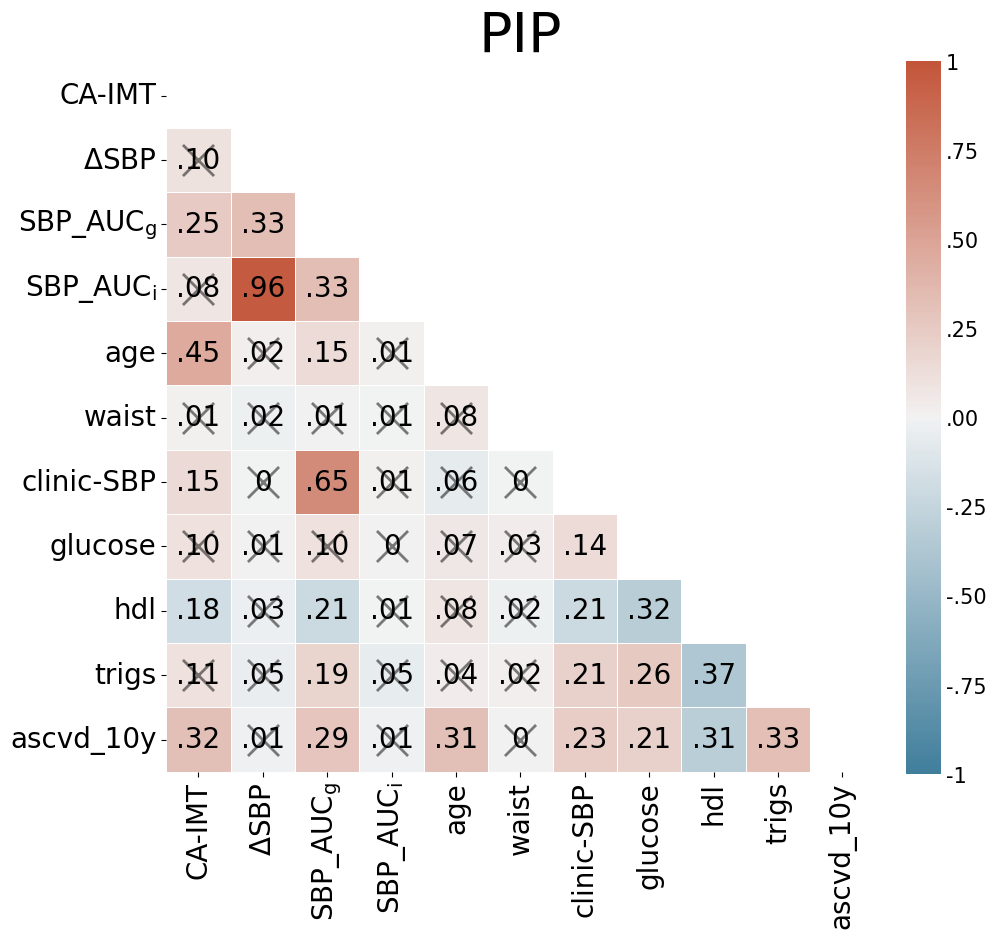

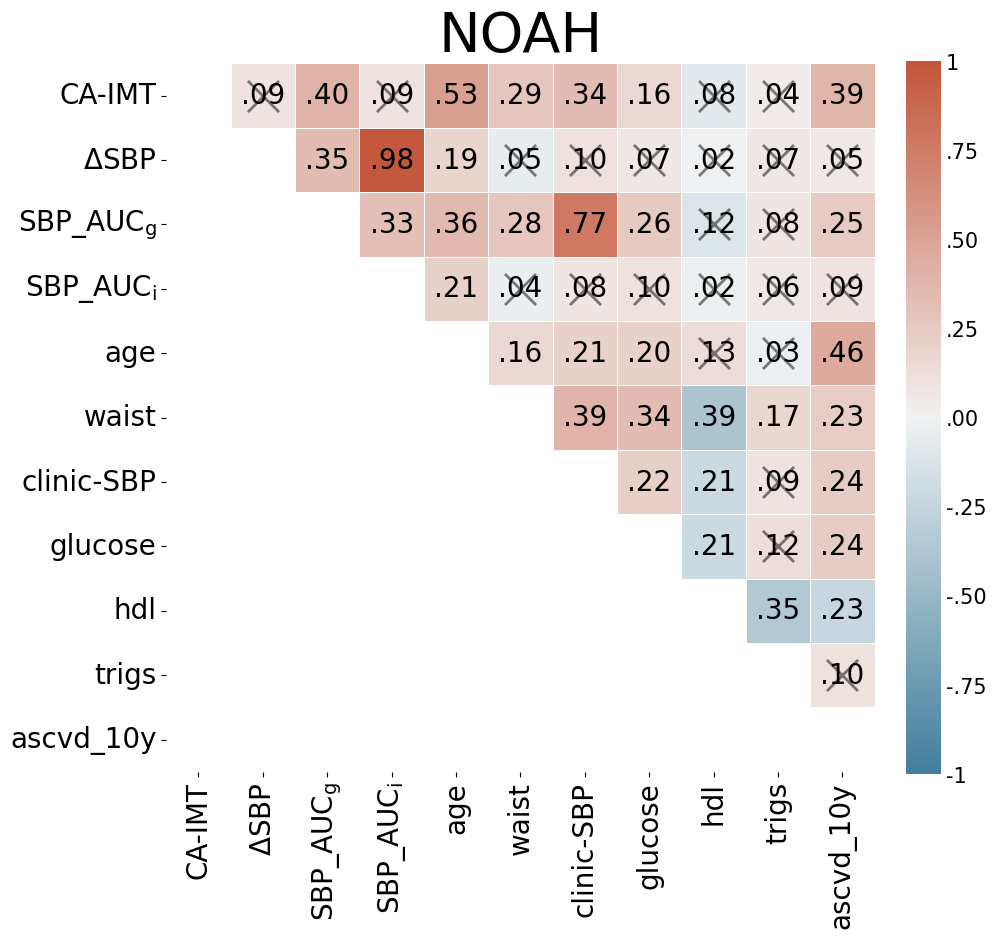

In [12]:
# BY STUDY
import matplotlib
from matplotlib.colors import TwoSlopeNorm

cmap = sns.diverging_palette(230, 20, as_cmap=True)

def func(x, pos):
    return f"{x:.2f}".replace("0.", ".").replace("1.00", "1")

fig, ax = plt.subplots(figsize=(10,10))
mask = np.triu(np.ones_like(cormat_pip, dtype=bool), k=1)

sns.heatmap(cormat_pip, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, 
            annot=True, cbar_kws={ "fraction":0.046, "pad":0.04, 
                                  'format':matplotlib.ticker.FuncFormatter(func)}, 
            annot_kws = {'fontsize': 20, 'color':'k'}, fmt=".2f",  ax=ax)

ax.tick_params(labelsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20, rotation=90)
ax.scatter(*np.argwhere(mask*pv_pip_fdr.to_numpy().T>0.05).T + 0.5,
           marker="x", color="black", s=500, linewidths=2, alpha=0.5)
plt.title("PIP", size=40)

for text in ax.get_children():
    if isinstance(text, matplotlib.text.Text) is False:
        continue
    s = text.get_text()
    text.set_text(s.replace("0.00", "0").replace("-0", "0").replace("0.", "."))
    
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(size=0, labelsize=15)
plt.savefig("../plots/corrmat_vars_pip.svg", dpi=300)
#plt.show()

fig, ax = plt.subplots(figsize=(10,10))

mask = np.tril(np.ones_like(cormat_pip, dtype=bool), k=-1)

sns.heatmap(cormat_noah, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, 
            annot=True, cbar_kws={ "fraction":0.046, "pad":0.04, 
                                  'format':matplotlib.ticker.FuncFormatter(func)}, 
            annot_kws = {'fontsize': 20, 'color':'k'}, fmt=".2f",  ax=ax)
ax.tick_params(labelsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20, rotation=90)

ax.scatter(*np.argwhere(mask*pv_noah_fdr.to_numpy().T>0.05).T + 0.5,
            marker="x", color="black", s=500, linewidths=2, alpha=0.5)
plt.title("NOAH", size=40)
for text in ax.get_children():
    if isinstance(text, matplotlib.text.Text) is False:
        continue
    s = text.get_text()
    text.set_text(s.replace("0.00", "0").replace("-0", "0").replace("0.", "."))

    
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(size=0, labelsize=15)
#plt.savefig("../plots/corrmat_vars_noah.svg", dpi=300)
plt.show()

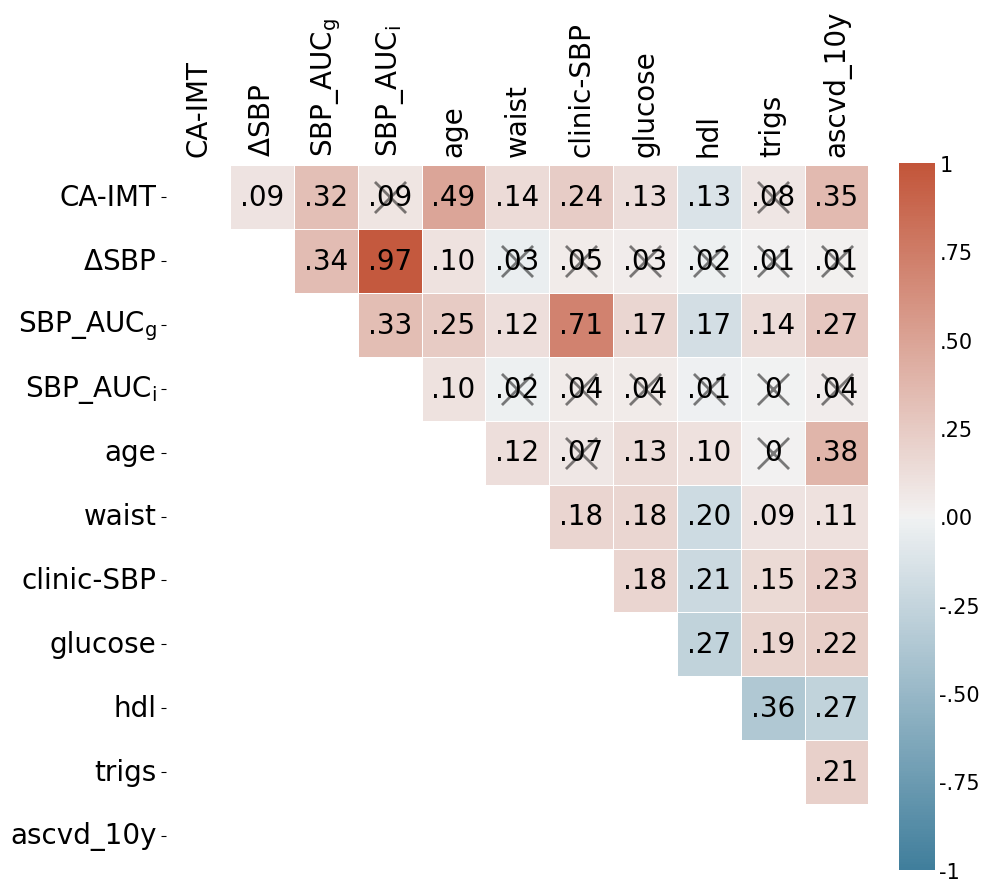

In [13]:
# Using the combined data, after standardization
cor_mat_full = pd.concat([zscore(project_data.query("STUDY=='PIP'").loc[:, my_vars + covariates], nan_policy="omit"),
                          zscore(project_data.query("STUDY=='NOAH'").loc[:, my_vars + covariates], nan_policy="omit")]
                         , axis=0).corr()
pv_full = pd.concat([zscore(project_data.query("STUDY=='PIP'").loc[:, my_vars + covariates], nan_policy="omit"),
                          zscore(project_data.query("STUDY=='NOAH'").loc[:, my_vars + covariates], nan_policy="omit")]
                         , axis=0).corr(method=pearsonr_pval)


pv_full_fdr = multipletests(np.concatenate((squareform(pv_full, checks=False),
                                            squareform(pv_full, checks=False))), 
                                           method="fdr_bh")[1]
pv_full_fdr = squareform(pv_full_fdr[:int(len(pv_full_fdr)/2)])
np.fill_diagonal(pv_full_fdr, 1) 
pv_full_fdr = pd.DataFrame(pv_full_fdr, 
                          columns = pv_full.columns, index=pv_full.index)
cor_mat_full.columns = renamed_vars
cor_mat_full.index = renamed_vars

pv_full_fdr.columns = renamed_vars
pv_full_fdr.index = renamed_vars


np.fill_diagonal(cor_mat_full.values, np.nan)

fig, ax = plt.subplots(figsize=(10,10))

mask = np.tril(np.ones_like(cor_mat_full, dtype=bool), k=-1)

sns.heatmap(cor_mat_full, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, 
            annot=True, cbar_kws={ "fraction":0.046, "pad":0.04, 
                                  'format':matplotlib.ticker.FuncFormatter(func)}, 
            annot_kws = {'fontsize': 20, 'color':'k'}, fmt=".2f",  ax=ax)
ax.tick_params(labelsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20, rotation=90)

ax.scatter(*np.argwhere(mask*pv_full_fdr.to_numpy().T>0.05).T + 0.5,
            marker="x", color="black", s=500, linewidths=2, alpha=0.5)
for text in ax.get_children():
    if isinstance(text, matplotlib.text.Text) is False:
        continue
    s = text.get_text()
    text.set_text(s.replace("0.00", "0").replace("-0", "0").replace("0.", "."))

ax.tick_params(axis='both', which='major', 
                labelbottom = False, 
                bottom=False, top = False, labeltop=True)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(size=0, labelsize=15)


plt.tight_layout()
#plt.savefig("../plots/supp_corrmat_vars_full.svg", dpi=300)
#plt.show()

We can see that ascvd_10y correlates with IMT and SBP_AUCg, so we will need to check that mediation still exists after considering both.

# 3 - Confounders: ascvd_10y

In order to test if associations hold after including ascvd_10y, we include this in the prediction vs observed association test as a covariate. Since there are differences in ascvd_10y between cohorts, we need to harmonize this variable too. However, for appropriateness, we need to embed this harmonization process in the cross-validation procedure, like we did when we ran all the models. Fortunately, so we can do this easily as we had saved the IDs of each fold.

In [14]:
from src.utils import get_results

m = "sbp_auc_g_both"
fold_ids = np.concatenate((np.load(f"../results/Y-mavg_bulbf_ccaf_M-{m}_task-both/predictions/ridge/fold_subject_ids.npz", 
                                   allow_pickle=True)['test_ids']))

xm_preds_df = get_results(f"../results/Y-mavg_bulbf_ccaf_M-{m}_task-both/predictions/ridge/model_xm.npz")
xmy_preds_df = get_results(f"../results/Y-mavg_bulbf_ccaf_M-{m}_task-both/predictions/ridge/model_xmy.npz")
my_preds_df = get_results(f"../results/Y-mavg_bulbf_ccaf_M-{m}_task-both/predictions/ridge/model_my.npz")
xy_preds_df = get_results(f"../results/Y-mavg_bulbf_ccaf_M-{m}_task-both/predictions/ridge/model_xy.npz")

xm_preds_df['ID'] = fold_ids
my_preds_df['ID'] = fold_ids
xmy_preds_df['ID'] = fold_ids
xy_preds_df['ID'] = fold_ids

So here we include ascvd_10y as a covariate and test if associations between predicted vs observed values hold. In addition, to calculate the coefficient of determination R2 after including this covariate, we regress out its effect from both predicted and observed values, and recalculate R2 again.

In [15]:
from confounds import Residualize
from scipy.stats import pearsonr
residualize=Residualize()
p_values_before = []
p_values_after = []

list_preds_confounders = []
for model, preds_df in zip(['xy', 'xm', 'my', 'xmy'],
                           [xy_preds_df, xm_preds_df, my_preds_df, xmy_preds_df]):
    print("model = ", model)
    preds_df['model'] = model
    for ii in range(1, 6):
        preds_seed_df = preds_df[preds_df.seed==ii]
        
        preds_seed_df['ascvd_10y_harm'] = pd.NA
        for i_fold in preds_seed_df.fold.unique():
            train_ids, test_ids = preds_seed_df[preds_seed_df.fold!=i_fold].ID, preds_seed_df[preds_df.fold==i_fold].ID
            test_idxs = preds_seed_df[preds_seed_df.fold==i_fold].index
            
            dat_train = pd.merge(pd.DataFrame({'ID': train_ids}), project_data, on='ID')
            dat_test = pd.merge(pd.DataFrame({'ID': test_ids}), project_data, on='ID')

            _, dat_test_harm = preprocess_cohorts_cv(dat_train.ascvd_10y.to_numpy(), dat_train.STUDY,
                                                     dat_test.ascvd_10y.to_numpy(), dat_test.STUDY, 
                                                     harmonize="standardize")
            preds_seed_df.loc[test_idxs, 'ascvd_10y_harm'] = dat_test_harm

        p_values_before.append(smf.ols('true~pred', 
                                data=preds_seed_df).fit().pvalues['pred'])
        p_values_after.append(smf.ols('true~pred + ascvd_10y_harm', 
                                data=preds_seed_df).fit().pvalues['pred'])
        
        residualize.fit(X=preds_seed_df.loc[:,["pred", "true"]], y=preds_seed_df.ascvd_10y_harm)
        
        resid_fold_df = pd.DataFrame(residualize.transform(X=preds_seed_df.loc[:,["pred", "true"]], 
                                                           y=preds_seed_df.ascvd_10y_harm), 
                                     columns=['pred_partial', 'true_partial'])
        list_preds_confounders.append(pd.concat([preds_seed_df.reset_index(), resid_fold_df], axis=1))
        print(f"seed {ii}, R2 (before): {r2_score(preds_seed_df.true, preds_seed_df.pred)}, " + 
              f"R2 (after): {r2_score(resid_fold_df.true_partial, resid_fold_df.pred_partial)}")
        print("")

p_after_fdr = multipletests(p_values_after, method="fdr_bh")[0]

print("XY model, p-values < 0.05 after:", sum(p_after_fdr[:5]))
print("XM model, p-values < 0.05 after:", sum(p_after_fdr[5:10]))
print("MY model, p-values < 0.05 after:", sum(p_after_fdr[10:15]))
print("XMY model, p-values < 0.05 after:", sum(p_after_fdr[15:]))

model =  xy
seed 1, R2 (before): 0.035714271147531784, R2 (after): 0.017768816228011408

seed 2, R2 (before): 0.01956490110649134, R2 (after): -0.00039110314045998074

seed 3, R2 (before): 0.030598510451970706, R2 (after): 0.015666335119202013

seed 4, R2 (before): 0.025215506524520204, R2 (after): 0.010777752107201555

seed 5, R2 (before): 0.01477643632132808, R2 (after): -0.003119667728531672

model =  xm
seed 1, R2 (before): 0.03428358026334066, R2 (after): 0.020022932329554766

seed 2, R2 (before): 0.040764754778588985, R2 (after): 0.027132649688505817

seed 3, R2 (before): 0.04352886571104342, R2 (after): 0.030026438415423518

seed 4, R2 (before): 0.021183148515204975, R2 (after): 0.007518647405495016

seed 5, R2 (before): 0.037905233160402285, R2 (after): 0.02370986174693801

model =  my
seed 1, R2 (before): 0.1185205546104775, R2 (after): 0.07673477368502624

seed 2, R2 (before): 0.118291560582648, R2 (after): 0.07570768367273151

seed 3, R2 (before): 0.11894070932506673, R2 (af

We can see except for a couple of runs in the XY model, all associations hold after including this covariate. The effect sizes (R2) decrease, as expected given the correlations between ascvd_10y and CA-IMT and SBP_AUCg.

In [16]:
import sys
sys.path.append("..")
from src.metrics import r2_med


def generate_r2_df(preds_df, true_col = "true", pred_col="pred"):
    from scipy.stats import bootstrap
    
    preds_grouped_df = preds_df.groupby(['seed', 'model'])
    n_points = preds_grouped_df['fold'].count().iloc[0]
    seeds = [1, 2, 3, 4, 5]
    
    r2_seed_df = []
    for seed in seeds:

        xy_t = preds_grouped_df.get_group((seed, 'xy'))[true_col].to_numpy()
        xy_p = preds_grouped_df.get_group((seed, 'xy'))[pred_col].to_numpy()
        res_xy = r2_score(xy_t, xy_p)

        xm_t = preds_grouped_df.get_group((seed, 'xm'))[true_col].to_numpy()
        xm_p = preds_grouped_df.get_group((seed, 'xm'))[pred_col].to_numpy()
        res_xm = r2_score(xm_t, xm_p)

        my_t = preds_grouped_df.get_group((seed, 'my'))[true_col].to_numpy()
        my_p = preds_grouped_df.get_group((seed, 'my'))[pred_col].to_numpy()
        res_my = r2_score(my_t, my_p)

        xmy_t = preds_grouped_df.get_group((seed, 'xmy'))[true_col].to_numpy()
        xmy_p = preds_grouped_df.get_group((seed, 'xmy'))[pred_col].to_numpy()
        res_xmy = r2_score(xmy_t, xmy_p)

        data = (xy_t, xy_p, my_t, my_p, xmy_t, xmy_p)
        res_med = r2_med(xy_t, xy_p, my_t, my_p, xmy_t, xmy_p)
            
        r2_df = pd.DataFrame({'xy': [res_xy],
                                 'xm':  [res_xm],
                                 'my': [res_my],  
                                 'xmy': [res_xmy], 
                                 'med': [res_med],
                                })
        r2_df['seed'] = seed
        r2_seed_df.append(r2_df)
    return pd.concat(r2_seed_df)

Now let's use the regressed-out observed and predicted values to compute the mediation effect. This will tell us if the combination of the different effect sizes after including ascvd_10y still triggers a meaningful mediation effect.

In [17]:
r2_before_confounds = generate_r2_df(pd.concat(list_preds_confounders))
r2_after_confounds = generate_r2_df(pd.concat(list_preds_confounders), 
                                    true_col = "true_partial", pred_col="pred_partial")

r2_before_confounds = pd.melt(r2_before_confounds, 
                             id_vars=["seed"], 
                             value_name='R2', var_name="model")
r2_before_confounds = r2_before_confounds.groupby(["model"])[['R2']].agg(['mean', 'std', 'sem'])

ci95_hi = []
ci95_lo = []
for i in r2_before_confounds.index:
    m, std, sem = r2_before_confounds.loc[i]
    ci95_hi.append(m + 1.96*sem)
    ci95_lo.append(m - 1.96*sem)

r2_before_confounds['ci95_hi'] = ci95_hi
r2_before_confounds['ci95_lo'] = ci95_lo


r2_after_confounds = pd.melt(r2_after_confounds, 
                             id_vars=["seed"], 
                             value_name='R2', var_name="model")
r2_after_confounds = r2_after_confounds.groupby(["model"])[['R2']].agg(['mean', 'std', 'sem'])

ci95_hi = []
ci95_lo = []
for i in r2_after_confounds.index:
    m, std, sem = r2_after_confounds.loc[i]
    ci95_hi.append(m + 1.96*sem)
    ci95_lo.append(m - 1.96*sem)

r2_after_confounds['ci95_hi'] = ci95_hi
r2_after_confounds['ci95_lo'] = ci95_lo

# R2 before
r2_before_confounds.round(3)

R2               ci95_hi ci95_lo
        mean    std    sem                
model                                     
med    0.073  0.004  0.002   0.076   0.070
my     0.118  0.000  0.000   0.119   0.118
xm     0.036  0.009  0.004   0.043   0.028
xmy    0.071  0.012  0.005   0.081   0.060
xy     0.025  0.008  0.004   0.033   0.018

In [18]:
# R2 after
r2_after_confounds.round(3)

R2               ci95_hi ci95_lo
        mean    std    sem                
model                                     
med    0.046  0.004  0.002   0.049   0.042
my     0.076  0.001  0.000   0.077   0.075
xm     0.022  0.009  0.004   0.029   0.014
xmy    0.039  0.013  0.006   0.050   0.027
xy     0.008  0.009  0.004   0.016  -0.000

So we still have a mediation effect of ~ 4.6% even after including ascvd_10y.